# NNIA 18/19 Project 2:  Gradient Descent & Backpropagation

## Deadline: 4. January 2018, 23:59

## 1. Multinomial Logistic Regression and Cross Validation $~$ (12 points)

In this exercise, you will implement a [multinomial logistic regression](https://en.wikipedia.org/wiki/Multinomial_logistic_regression) model with tensorflow for Fashion-MNIST dataset. Cross Validation will be used to find the best **regularization parameter** $\lambda$ for the L2-regularization term. Fashion-MNIST dataset is similar to the sklearn Digit dataset you used in the Project 1. It contains 60,000 training images and 10,000 testing images. Each example is a 28×28 grayscale image, associated with a label from 10 classes.

![Neural Network](https://s3-eu-central-1.amazonaws.com/zalando-wp-zalando-research-production/2017/08/fashion-mnist-sprite.png)

Multinomial logistic regression is a probabilistic, linear classifier. It is parametrized by a weight matrix $W$ and a bias vector $b$. Classification is done by projecting an input vector onto a set of hyperplanes, each of which corresponds to a class. The distance from the input to a hyperplane reflects the probability that the input is a member of the corresponding class.

Mathematically, the probability that an input vector $\bf{x} \in \mathbb{R}^p$ is a member of a class $i$ can be written as:
$$P(Y=i|\textbf{x}, W, b) = softmax(W\textbf{x} + b)_i = \frac{e^{W_i\textbf{x} + b_i}}{\sum_j{e^{W_j\textbf{x} + b_j}}}$$
where $W \in \mathbb{R}^{c \times p}$, $b \in \mathbb{R}^c$ and $W_i \in \mathbb{R}^p$.

The model’s prediction $y_{pred}$ is the class whose probability is maximal, specifically:
$$y_{pred} = argmax_iP(Y=i|\textbf{x}, W, b)$$

We use cross-entropy loss with L2 regularization.

### 1.1 Dataset and Normalization

Load **Fashion-MNIST** dataset and normalized it.

In [6]:
import os
import struct
import numpy as np
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist
(X_trainval, Y_trainval), (X_test, Y_test) = fashion_mnist.load_data()

In [7]:
X_trainval = np.reshape(X_trainval, (X_trainval.shape[0],  X_trainval.shape[1] *  X_trainval.shape[2]))
print('The X_trainval has the following shape:')
print('Rows: %d, columns: %d' % (X_trainval.shape[0], X_trainval.shape[1]))

The X_trainval has the following shape:
Rows: 60000, columns: 784


In [8]:
X_test = np.reshape(X_test, (X_test.shape[0],  X_test.shape[1] *  X_test.shape[2]))
print('The X_test has the following shape:')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

The X_test has the following shape:
Rows: 10000, columns: 784


Normalize the data. Subtract the mean and divide by the standard deviation.

In [9]:
def data_normalization(X_trainval, X_test):
    train = np.copy(X_trainval)
    test  = np.copy(X_test)
    for row in np.transpose(train):
        deviation = np.std(row)
        if(deviation != 0):
            row= row / deviation
        row -= np.mean(row)
        
    for row in np.transpose(test):
        deviation = np.std(row)
        if(deviation != 0):
            row = row / deviation
        row -= np.mean(row)
    
    return train, test

In [10]:
# The normalization should be done on X_train and X_test. 
# The normalized data should have the exactly same shape as the original data matrix.

X_trainval, X_test = data_normalization(X_trainval, X_test)
print(np.shape(X_trainval),np.shape(X_test))

(60000, 784) (10000, 784)


---
**Points:** $0.0$ of $1.0$
**Comments:** None

---

### 1.2 Define the Computation Graph

In [10]:
# Here the global configuration of this program is 
# defined, which you shouldn't change.

class global_config(object):
    lr = 0.0001  # learning rate
    img_h = 28  # image height
    img_w = 28  # image width
    num_class = 10  # number of classes
    num_epoch = 20  # number of training epochs
    batch_size = 16  # batch size
    K = 3  # K-fold cross validation
    num_train = None  # the number of training data
    lambd = None  # the factor for the L2-regularization

config = global_config()
config.num_train = X_trainval.shape[0]

In [11]:
def train_val_split(X_trainval, Y_trainval, i, K):
    """
    sklearn library is not allowed to use here.
    
    K is the total number of folds and i is the current fold.
    
    Think about how to deal with the case when the number of 
    training data can't be divided by K evenly.
    #TODO: Implement"""
    elements,_ = np.shape(Y_trainval)
    surplus = elements % K
    size_big = (elements/surplus)+1
    size_small = elements
    
    if i < surplus:
        slice_beg = i*size_big
        slice_end = slice_beg + size_big
        
    if i >= surplus:
        slice_beg = surplus*size_big+(i-surplus)*size_small
        slice_end = slice_beg + size_small
        
    X_val = X_trainval[slice_beg:slice_end]
    Y_val = Y_trainval[slice_beg:slice_end]
    
    X_train_lower = X_trainval[:slice_beg]
    X_train_upper = X_trainval[slice_end:]
    X_train       = np.concatenate((X_train_lower, X_train_upper))
    
    Y_train_lower = Y_trainval[:slice_beg]
    Y_train_upper = Y_trainval[slice_end:]
    Y_train       = np.concatenate((Y_train_lower, Y_train_upper))

    
        
    return X_train, X_val, Y_train, Y_val

---
**Points:** $0.0$ of $2.0$
**Comments:** None

---

In [13]:
def shuffle_train_data(X_train, Y_train):
    """called after each epoch"""
    perm = np.random.permutation(len(Y_train))
    Xtr_shuf = X_train[perm]
    Ytr_shuf = Y_train[perm]
    return Xtr_shuf, Ytr_shuf

np.shape(X_test)

(10000, 784)

In [ ]:
"""
training
"""
class logistic_regression(object):
    
    def __init__(self, X, Y_gt, config, name):
        """
        :param X: the training batch, which has the shape [batch_size, n_features].
        :param Y_gt: the corresponding ground truth label vector.
        :param config: the hyper-parameters you need for the implementation.
        :param name: the name of this logistic regression model which is used to
                     avoid the naming confict with the help of tf.variable_scope and reuse.
       
        Define the computation graph within the variable_scope here. 
        First define two variables W and b with tf.get_variable.
        Then do the forward pass.
        Then compute the cross entropy loss with tensorflow, don't forget the L2-regularization.
        The Adam optimizer is already given. You shouldn't change it.
        Finally compute the accuracy for one batch
        """
        self.config = config
        with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
            #TODO: Define two variables and the forward pass.
            W = tf.get_variable("W",shape=[samples, features]) 
            b = tf.get_variable("b",shape=[features])
    forwardPass = np.add (np.dot(np.transpose(W),X),b)
    loss = tf.nn.softmax_cross_entropy_with_logits(forwardPass)
    l2regularizer = tf.nn.l2_loss(W)
    loss = loss + lamda*l2regularizer
    self._loss = np.reduce_mean(loss)
            #TODO: Compute the cross entropy loss with L2-regularization.
            i = 0
            for yhat in self.train_step
                if (yhat ==Y_gt[i])
                self._num_acc = self._num_acc + 1 
                
                i++ 
            self._num_acc = self._num_acc/ i 
            # Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent 
            # to update network weights iteratively.
            # It will be introduced in the lecture when talking about the optimization algorithms.
            self._train_step = tf.train.AdamOptimizer(config.lr).minimize(self._loss)
            
            #TODO: Compute the accuracy
            
    @property
    def train_op(self):
        return self._train_step
    
    @property
    def loss(self):
        return self._loss
    
    @property
    def num_acc(self):
        return self._num_acc

---
**Points:** $0.0$ of $2.0$
**Comments:** None

---

In [ ]:
def testing(model, X_test, Y_test, config):
    """ 
    Go through the X_test and use sess.run() to compute the loss and accuracy.
    
    Return the total loss and the accuracy for X_test.
    
    Note that this function will be used for the validation data
    during training and the test data after training.
    """
    num_test = X_test.shape[0]
    total_cost = 0
    accs = 0
    #TODO: Implement
    return total_cost / len(Y_test), accs / len(Y_test)

---
**Points:** $0.0$ of $2.0$
**Comments:** None

---

In [ ]:
def train(model, X_train, X_val, Y_train, Y_val, config):
    """
    Train the model with sess.run().
    
    You should shuffle the data after each epoch and
    evaluate training and validation loss after each epoch.
    
    Return the lists of the training/validation loss and accuracy.
    """
    cost_trains = []
    acc_trains = []
    cost_vals = []
    acc_vals = []
    
    for i in range(config.num_epoch):
       #TODO: Implement
        cost_trains.append(cost_train)
        acc_trains.append(acc_train)
        print("Epoch: %d :" % (i + 1))
        print("Train Loss: %f" %  cost_train)
        print("Training acc: %f" % acc_train)
        cost_vals.append(cost_val)
        acc_vals.append(acc_val)
        print("Validation Loss: %f" % cost_val)
        print("Validation acc: %f" % acc_val)
    return cost_trains, acc_trains, cost_vals, acc_vals

---
**Points:** $0.0$ of $2.0$
**Comments:** None

---

### 1.3 Cross Validation

Implement cross validation to find an optimal value of $\lambda$. The optimal hyper-parameters should be determined by the validation accuracy. The test set should only be used in the very end after all other processing, e.g. hyper-parameter choosing.

In [30]:
"""
Initialization
"""
# Use cross validation to choose the best lambda for the L2-regularization from the list below
lambda_list = [100, 1, 0.1]


X = tf.placeholder(tf.float32, [None, config.img_h * config.img_w])
Y_gt = tf.placeholder(tf.int64, [None, ])

for lambd in lambda_list:
    val_loss_list = []
    config.lambd = lambd
    print("lambda is %f" % lambd)
    
    for i in range(config.K):
        # Prepare the training and validation data
        X_train, X_val, Y_train, Y_val = train_val_split(X_trainval, Y_trainval, i, config.K)
        
        # For each lambda and K, we build a new model and train it from scratch
        model = logistic_regression(X, Y_gt, config, name=str(lambd)+'_'+str(config.K))
        
        with tf.Session() as sess:
            
            # Initialize the variables of the model
            sess.run(tf.global_variables_initializer())
            
            # Train the model
            cost_trains, acc_trains, cost_vals, acc_vals = train(model, X_train, X_val, Y_train, Y_val, config)
            
        val_loss_list.append(cost_vals[-1])
        
    print("The validation loss for lambda %f is %f" % (lambd, np.mean(val_loss_list)))
    

lambda is 100.000000
(784, 60000) (60000,)


ValueError: not enough values to unpack (expected 2, got 1)

### 1.4 Combine Train and Validation data.

Use the hyper-parameters you choose from the cross validation to re-train the model.

In [ ]:
config.lambd =  #TODO: Choose the best lambda
model = logistic_regression(X, Y_gt, config, name='trainval')
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    cost_trains, acc_trains, cost_tests, acc_tests = train(model, X_trainval, X_test, Y_trainval, Y_test, config)

print("The final test acc is %f" % acc_tests[-1])

---
**Points:** $0.0$ of $0.5$
**Comments:** None

---

### 1.5 Questions

1. What is the impact of k in k-fold cross validation?

2. What will happen to the training if you change the $\lambda$ for L2-regularization?

3. Why do we perform the gradient descent on a batch of the data rather than all of the data?

4. Why does the loss increase, when the learning rate is too large?

5. Do we apply L2-regularization for the bias $b$?

*Answer:* 

---
**Points:** $0.0$ of $2.5$
**Comments:** None

---

## 2. Getting to know Back-Propagation in details $~$ (18 points)

In the following exercise you would build a **feed-forward network** from scratch using **only** Numpy. For this, you also have to implement **Back-propagation** in python. Additionally, this network should have the option of **L2 regularization** enabled within it.

**Before you start**: In this exercise you will implement a single hidden layer feedforward neural network. In case you are unfamiliar with the terminology and notation used here, please consult chapter 6 of the Deep Learning Book before you proceed.

Generally speaking, a feedword neural network with a single hidden layer can be represented by the following function $$ f(x;\theta) = f^{(2)}(f^{(1)}(f^{(0)}(x)))$$ where $f^{(0)}(x)$ is the input layer, $f^{(1)}(.)$ is the so called hidden layer, and $f^{(2)}(.)$ is the ouput layer of the network. $\theta$ represents the parameters of the network whose values will be learned during the training phase.

The network that you will implement in this exercise has the following layers:
* $f^{(0)}(x) = \mathbf{X}$, with $\mathbf{X} \in \mathbb{R}^{b,p}$ where $b$ is the batch size and $p$ is the number of features.
* $f^{(1)}(.) = \sigma(\mathbf{X} \mathbf{W_1}+b_1)$, with $\mathbf{X} \in \mathbb{R}^{b, p}$, $\mathbf{W_1} \in \mathbb{R}^{p,u_1}$, $\textbf{b}_1 \in \mathbb{R}^{u_1}$ where $u_1$ is the number of **hidden units**. Additonally, $\sigma(x) = \frac{1}{1 + \exp{(-x})}$ is the **sigmoid** function.
* $f^{(2)}(.) = softmax(\mathbf{X} \mathbf{W_2}+b_2)$, with $\mathbf{X} \in \mathbb{R}^{b, u_1}$, $\mathbf{W_2} \in \mathbb{R}^{u_1,u_2}$, $\textbf{b}_2 \in \mathbb{R}^{u_2}$ where $u_2$ is the number of **output classes** in this particular layer.

Note that both, $\sigma(x)$ are applied **elementwise**. Further, the addition with the bias vector is also applied **elementwise** to each row of the matrix $\mathbf{X} \mathbf{W}$.

In [11]:
import numpy as np
from scipy.special import expit
import math
from scipy.special import expit as sigmoid1
from scipy.stats import logistic

class Fully_connected_Neural_Network(object):
    """ Fully-connected neural network with one hidden layer.

    Parameters
    ------------
    n_output : int
        Number of class labels.
        
    n_features : int
        Number of input features.
        
    n_hidden : int
        Number of hidden units.
        
    l2 : float
        regularization parameter
        0 means no regularization
        
    epochs : int
        One Epoch is when the entire dataset is passed forward and backward through the neural network only once.
        
    lr : float
        Learning rate.
        
    batchsize : int
        Total number of training examples present in a single batch.
        

    Attributes
    -----------
    w1 : array, shape = [n_features, n_hidden_units]
        Weight matrix for input layer -> hidden layer.
    w2 : array, shape = [n_hidden_units, n_output_units]
        Weight matrix for hidden layer -> output layer.
    b1 : array, shape = [n_hidden_units, ]
        Bias for input layer-> hidden layer.
    b2 : array, shape = [n_output_units, ]
        Bias for hidden layer -> output layer.

    """
    # Points: 2.0
    def __init__(self, n_output, n_features, n_hidden=30,
                 l2=0.0, epochs=50, lr=0.001, batchsize=1):
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.lr = lr
        self.batchsize = batchsize
        #TODO Initialize weights and biases with np.random.uniform or np.random.normal and specify the shape
        w1 = np.random.uniform(low = 0, high = 11, size= self.n_features*self.n_hidden)
        self.w1 = w1.reshape(self.n_features, self.n_hidden)
        w2 = np.random.uniform(low = 0, high = 11, size= self.n_hidden*self.n_output)
        self.w2 = w2.reshape(self.n_hidden, self.n_output)
        
        self.cost_iter = np.zeros([epochs * batchsize])
        #bias mai dimension hidden aur output ka hoga 
        self.b1 = np.random.uniform(low = 0, high = 1, size = self.n_hidden)
        self.b2 = np.random.uniform(low = 0, high = 1, size = self.n_output)

        
    def labelsEncoding(self, y, k):

        #res = np.zeros([k])
        #res[y] = 1
        res = np.zeros([y.shape[0],k])
        for i in range(y.shape[0]):
            res[i,y[i]] = 1 
        return res
        
        
    # Points: 0.5
    def sigmoid(self, z):
        """Compute sigmoid function"""
        return  sigmoid1(z)
        #TODO Implement
      

    # Points: 0.5
    def sigmoid_gradient(self, z):
        """Compute gradient of the sigmoid function"""
        return logistic.pdf(z)

    
    # Points: 1.0
    def softmax(self, z):
        """Compute softmax function.
        Implement a stable version which 
        takes care of overflow and underflow.
        """        
        #TODO Implement
        numerator = np.exp(z - np.amax(z))
        denominator = np.sum(numerator)
        softmax_output = np.exp(z - np.amax(z))/denominator 
        return softmax_output
    
    def softmax_computation(self, x):
        
        #TODO Implement
        e_x = np.exp(x - np.max(x))
        z = e_x / e_x.sum(axis=0)
        y = np.zeros(z.shape)
        for i in range(z.shape[0]):
            y[i][np.argmax(z[i])] = 1
            
        return y 

        
    # Points: 2.0
    def forward(self, X):
        """Compute feedforward step

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            
        Returns
        ----------
        z2 : array,
            Input of the hidden layer.
        a2 : array,
            Output of the hidden layer.
        z3 : array,
            Input of the output layer.
        a3 : array,
            Output of the output layer.

        """
        # TODO Implement
        z2 = np.dot(X, self.w1) + self.b1        
        
        a2 = self.sigmoid(z2)        
        
        z3 = np.dot(a2, self.w2) + self.b2      
        
        a3 = self.softmax(z3)
        
        # Checking other method for softmax calculation
        temp = self.softmax_computation(z3)
        
        return z2, a2, z3, a3
        
    # Points: 0.5
    def L2_regularization(self, lambd):
        """Implement L2-regularization loss"""
        
        x = lambd * np.sum(np.square(self.w1))
        y = lambd * np.sum(np.square(self.w2))
        
        return x, y
        
    # Points: 2.0
    def loss(self, y_enc, output, epsilon=1e-12):
        """Implement total loss.

        Parameters
        ----------
        y_enc : array, one-hot encoded labels.
        
        output : array, output of the output layer

        Returns
        ---------
        cost : float, total loss.

        """
        #TODO Implement        
        regul21, regul22 = self.L2_regularization(self.l2)
        regul1 = regul21
        regul2 = regul22
        sub = np.sum(np.square(np.subtract(y_enc, output)))
        cost =  sub + regul1 + regul2
        return cost
        
    
    # Points: 4.0
    def compute_gradient(self, X, a2, a3, z2, z3, y_enc):
        """ Compute gradient using backpropagation.

        Parameters
        ------------
        X : array, Input.
        a2 : array, output of the hidden layer.
        a3 : array, output of the output layer.
        z2 : array, input of the hidden layer.
        y_enc : array, one-hot encoded labels.

        Returns
        ---------
        grad1 : array, Gradient of the weight matrix w1.
        grad2 : array, Gradient of the weight matrix w2.
        grad3 : array, Gradient of the bias vector b1.
        grad4 : array, Gradient of the bias vector b2.
        """
        #TODO Implement
        dz3   = np.subtract(a3, y_enc)
        
        
        ##Compute Gradient of Softmax
        e_x = np.exp(np.subtract(z3, np.max(z3)))
        # print(e_x)
        h2_ = (e_x / np.sum(e_x, axis=0)) + np.square((e_x)/(np.sum(e_x,axis=0)))

        delta2 = np.multiply(h2_, np.subtract(y_enc, a3))
        
        h1_ = self.sigmoid_gradient(z2)
        delta1 = np.multiply(np.matmul(self.w2, np.transpose(delta2)), np.transpose(h1_))
        
        grad1 = np.matmul(np.transpose(X), np.transpose(delta1))
        grad2 = np.matmul(np.transpose(a2), delta2)
        
        # regularize
        regul21 = 2 * self.l2 * self.w1
        regul22 = 2 * self.l2 * self.w2
        
        res1 = np.add (grad1, regul21)
        res2 = np.add (grad2, regul22)

        grad3 = self.b1
        grad4 = self.b2
        
        #res1 is the Gradient of the weight matrix w1 with L2 reg
        #res2 is the Gradient of the weight matrix w2 with L2 reg
        return res1, res2, grad3, grad4 
        
    # Points: 1.0
    def inference(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, Input.

        Returns:
        ----------
        y_pred : array, Predicted labels.

        """
        # TODO Implement
        z2 = np.dot(X, self.w1)         
        
        a2 = self.sigmoid(z2)        
        
        z3 = np.dot(a2, self.w2)       
        
        a3 = self.softmax(z3)       
                
        y_pred = a3 > 0.5
        return y_pred
    
    
    def shuffle_train_data(self, X, Y):
        """called after each epoch"""
        perm = np.random.permutation(Y.shape[0])
        X_shuf = X[perm]
        Y_shuf = Y[perm]
        return X_shuf, Y_shuf
    
    # Points: 2.0
    def train(self, X_train, Y_train, verbose=False):
        """ Fit the model.

        Parameters
        -----------
        X : array, Input.
        y : array, Ground truth class labels.
        verbose : bool, Print the training progress

        Returns:
        ----------
        self

        """
        #TODO Initialization
        self.cost_ = []
        

        for e in range(self.epochs):
            batch_size = math.floor(X_train.shape[0]/self.batchsize)
            acc_grad1 = np.zeros(self.w1.shape)
            acc_grad2 = np.zeros(self.w2.shape)
            Y_hot = self.labelsEncoding(Y_train, 10)
            
            for i in range(self.batchsize):
                X_batch = X_train[i * batch_size:(i+1) * batch_size - 1]
                Y_batch = Y_hot[i*batch_size:(i+1)*batch_size-1]
                
                # feedforward
                z2, a2, z3, a3 = self.forward(X_batch)
                grad1, grad2, grad3, grad4 = self.compute_gradient(X_batch,a2, a3 ,z2,z3, Y_batch)
                acc_grad1 = np.add(acc_grad1, grad1)
                acc_grad2 = np.add(acc_grad2, grad2)
                
                _,_,_, output1 = self.forward(X_batch)
                self.cost_iter[(e * self.batchsize + i)] = self.loss(Y_batch, output1)
        
            if verbose:
                print('\nEpoch: %d/%d' % (e+1, self.epochs))


                # feedforward and loss computation
                _,_,_, output= self.forward(X_train)

                #self.cost_.append(cost)
                                
                self.cost_.append(self.loss(Y_hot, output))
                self.w1 = np.subtract(self.w1, np.multiply(self.lr, acc_grad1))
                self.w2 = np.subtract(self.w2, np.multiply(self.lr, acc_grad2))

                # compute gradient via backpropagation and update the weights
                

        return self

---
**Points:** $0.0$ of $15.5$
**Comments:** None

---

In [26]:
nn = Fully_connected_Neural_Network(n_output=10, 
                                    n_features= X_trainval.shape[1], 
                                    n_hidden=50, 
                                    l2=0.1, 
                                    epochs=100, 
                                    lr=0.001,
                                    batchsize=50)

In [13]:
nn.train(X_trainval, Y_trainval, verbose=True)


Epoch: 1/5

Epoch: 2/5

Epoch: 3/5

Epoch: 4/5

Epoch: 5/5


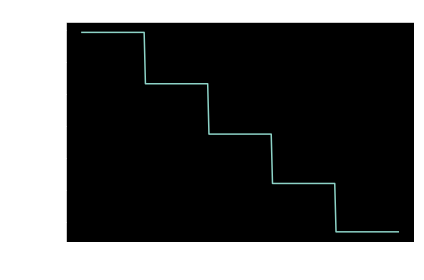

In [20]:
import matplotlib.pyplot as plt

# Plot the training error for every iteration
# in every epoch

# TODO Implement
x_axis = np.arange(nn.cost_iter.shape[0])
plt.plot(x_axis, nn.cost_iter)
# # # Name the plot
# # # TODO Implement
plt.title("training error for every iteration in every epoch")
plt.xlabel('iterations')
plt.ylabel('costs')
plt.tight_layout()
plt.show()


---
**Points:** $0.0$ of $1.0$
**Comments:** None

---

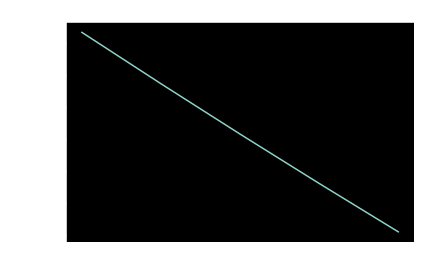

In [21]:
# Plot the training error in every epoch
# TODO Implement
x_axis = np.arange(len(nn.cost_))
plt.plot(x_axis, nn.cost_)
# # # Name the plot
# # # TODO Implement
plt.title("training error for every epoch")
plt.xlabel('iterations')
plt.ylabel('epochs')
plt.tight_layout()
plt.show()

---
**Points:** $0.0$ of $1.0$
**Comments:** None

---

In [24]:
# Compute Training Accuracy
# TODO Implement
# Compute Training Accuracy
# TODO Implement
y_pred = nn.inference(X_trainval)


count = 0
index = 0
for i in y_pred:
    if Y_trainval[index] == np.argmax(i) :
        count = count+1
    index = index+1

acc=count/index


print('Training accuracy: %.2f%%' % (acc * 100))

# Compute Test Accuracy
# TODO Implement
y_pred1 = nn.inference(X_test)

count1 = 0
indx1 = 0
for i in y_pred1:
   # print(i)
   # print(y_train[indx], np.max(i), i)
    if Y_test[indx1] == np.argmax(i) :
        count1 = count1+1
    indx1 = indx1+1

acc1=count1/indx1
print('Test accuracy: %.2f%%' % (acc1 * 100))


Training accuracy: 10.00%
Test accuracy: 10.00%


---
**Points:** $0.0$ of $0.5$
**Comments:** None

---

## Submission instructions
You should provide a single Jupyter notebook (.ipynb file) as the solution. Put the names and student ids of your team members below. **Make sure to submit only 1 solution to only 1 tutor.**

- Jane Doe, 123456
- Jane Doe, 123456
- Jane Doe, 123456

## Points: 0.0 of 30.0 points